In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib


In [2]:
#overcast 20191030T161529_VOOR
#partly 20191112T183029_VOOR
#clear 20190511T122529_VOOR
PATH = '/home/arnold/clouds_detection/VOOR'
data_dir = pathlib.Path(PATH)
#resize image 
# sz=224
# List containing the entries in the directory given by PATH
os.listdir(PATH)
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)
batch_size = 32
img_height = 720
img_width = 1080

1349


In [3]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [4]:
for f in list_ds.take(7):
  print(f.numpy())

b'/home/arnold/clouds_detection/VOOR/night/20190102T000030_VOOR.jpg'
b'/home/arnold/clouds_detection/VOOR/overcast/20190505T092028_VOOR.jpg'
b'/home/arnold/clouds_detection/VOOR/overcast/20190505T124529_VOOR.jpg'
b'/home/arnold/clouds_detection/VOOR/snow/20180302T124032_VOOR.jpg'
b'/home/arnold/clouds_detection/VOOR/overcast/20190202T205529_VOOR.jpg'
b'/home/arnold/clouds_detection/VOOR/night/20190101T050028_VOOR.jpg'
b'/home/arnold/clouds_detection/VOOR/few/20191102T192529_VOOR.jpg'


In [5]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['clear' 'few' 'night' 'overcast' 'rain' 'scattered' 'snow']


In [6]:
#split into training and val 
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [7]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())


1080
269


In [8]:
def get_label(file_path):
  # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
    one_hot = parts[-2] == class_names
  # Integer encode the label
    return tf.argmax(one_hot)

In [9]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
  # resize the image to the desired size
    return tf.image.resize(img, [img_height, img_width])

In [10]:
def process_path(file_path):
    label = get_label(file_path)
  # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
#     img = image.img_to_array(img)
    height, width, channels = img.shape
#     img = img[0:int(height/3), 0:width] #1/3 top 
    img = img[0:int(height/2), 0:width] #half
    print(img.shape)
    return img, label

In [11]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)


(360, 1080, 3)
(360, 1080, 3)


In [33]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy().shape)

Image shape:  (32, 360, 1080, 3)
Label:  (32,)


In [14]:
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

In [15]:
print(train_ds)

<PrefetchDataset shapes: ((None, 360, 1080, 3), (None,)), types: (tf.float32, tf.int64)>


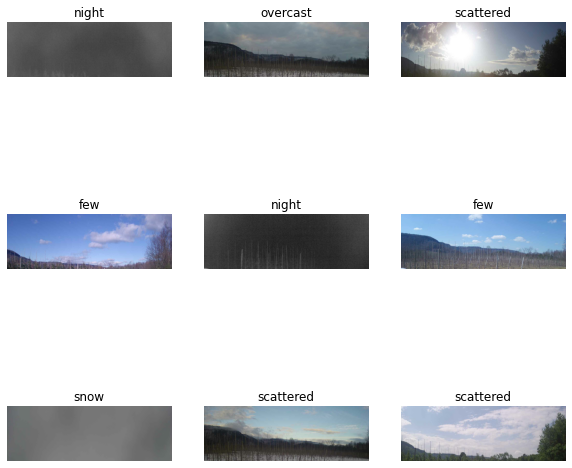

In [16]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = label_batch[i]
    plt.title(class_names[label])
    plt.axis("off")

In [17]:
#RGB channel values are in the [0, 255] range. Bad for neural network; want input values small. 
#Standardize values to be in the [0, 1] by using a Rescaling layer.
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)


In [18]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 1.0


In [19]:
num_classes = len(class_names)
len(class_names)

7

In [20]:
#Data augmentation - generating additional training data from your existing examples by augmenting then using random transformations that yield believable-looking images
data_augmentation = keras.Sequential(
  [
#       tf.keras.layers.experimental.preprocessing.RandomCrop(
#     240, 1280
# )
#     layers.experimental.preprocessing.RandomFlip("horizontal", 
#                                                  input_shape=(img_height, 
#                                                               img_width,
#                                                               3)),
#     layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

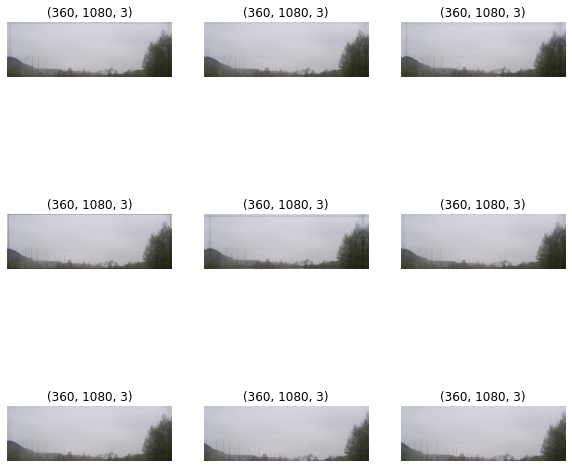

In [31]:
# data_augmentation(image_batch)
#viz augmented images
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.title(augmented_images[0].shape)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [22]:
num_classes = len(class_names)
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [23]:
#compile the model (To view training and validation accuracy for each training epoch, pass the metrics argument)

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [32]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, None, 1080, 3)     0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, None, 1080, 3)     0         
_________________________________________________________________
conv2d (Conv2D)              (None, None, 1080, 16)    448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, None, 540, 16)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, 540, 32)     4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, None, 270, 32)     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, 270, 64)    

In [26]:
epochs = 25
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/25
34/34 [==============================] - 6s 174ms/step - loss: 0.1848 - accuracy: 0.9333 - val_loss: 0.2836 - val_accuracy: 0.9108
Epoch 2/25
34/34 [==============================] - 6s 177ms/step - loss: 0.1355 - accuracy: 0.9528 - val_loss: 0.2234 - val_accuracy: 0.9480
Epoch 3/25
34/34 [==============================] - 6s 165ms/step - loss: 0.1445 - accuracy: 0.9519 - val_loss: 0.1412 - val_accuracy: 0.9591
Epoch 4/25
34/34 [==============================] - 6s 173ms/step - loss: 0.1275 - accuracy: 0.9528 - val_loss: 0.1626 - val_accuracy: 0.9591
Epoch 5/25
34/34 [==============================] - 6s 173ms/step - loss: 0.1380 - accuracy: 0.9491 - val_loss: 0.2202 - val_accuracy: 0.9368
Epoch 6/25
34/34 [==============================] - 5s 161ms/step - loss: 0.0884 - accuracy: 0.9657 - val_loss: 0.1568 - val_accuracy: 0.9665
Epoch 7/25
34/34 [==============================] - 6s 183ms/step - loss: 0.1300 - accuracy: 0.9620 - val_loss: 0.3123 - val_accuracy: 0.9071
Epoch 

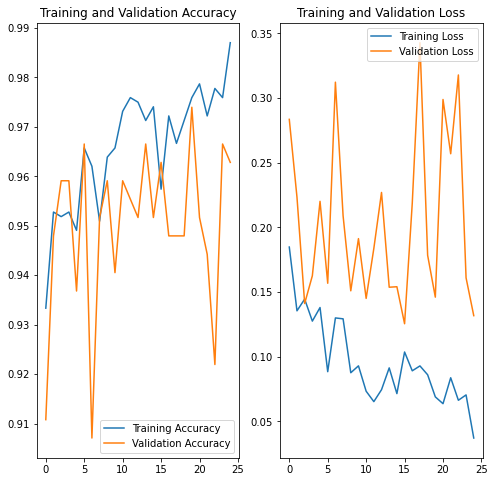

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

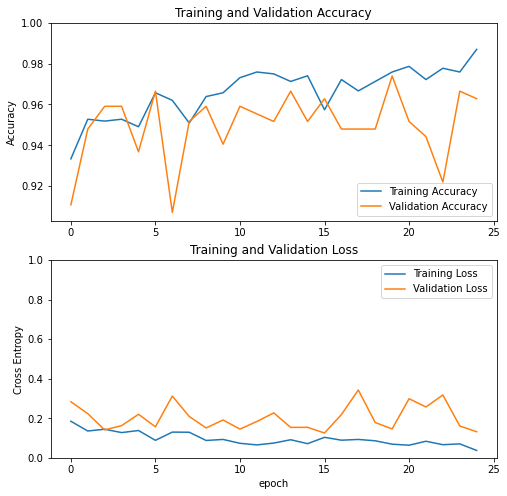

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [30]:
folder_path = '/home/mesonet/cam_photos/2018/08/17/ESSX'
from keras.preprocessing import image

# load all images into a list
paths = []
images = []
for img in os.listdir(folder_path):
    img = os.path.join(folder_path, img)
    paths.append(img)
    img = image.load_img(img, target_size=(img_height, img_width))
    img = image.img_to_array(img)
    height, width, channels = img.shape
    img = img[0:int(height/3), 0:width]
    img = np.expand_dims(img, axis=0)
    images.append(img)
# print(images[1])
# stack up images list to pass for prediction
images = np.vstack(images)
#print(paths)
# for i in paths:
#     PIL.Image.open(i)
#

classes = model.predict_classes(images, batch_size=32)
print(class_names)
print(classes)
predictions = model.predict(images)
score = tf.nn.softmax(predictions[0])
#print(predictions)
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
#print(paths[-1])
#PIL.Image.open(paths[-1])
plt.figure(figsize=(10, 10))
for i in range(15):
    ax = plt.subplot(5, 3, i + 1)
    plt.imshow(images[i].astype("uint8"))
#     predictions = model.predict(image[i])
#     score = tf.nn.softmax(predictions[0])
#     plt.title(class_names[np.argmax(score)], 100 * np.max(score))
    plt.title(class_names[classes[i]])
    plt.axis("off")

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


ValueError: in user code:

    /root/anaconda3/envs/py3.4/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:1462 predict_function  *
        return step_function(self, iterator)
    /root/anaconda3/envs/py3.4/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:1452 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /root/anaconda3/envs/py3.4/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /root/anaconda3/envs/py3.4/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /root/anaconda3/envs/py3.4/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /root/anaconda3/envs/py3.4/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:1445 run_step  **
        outputs = model.predict_step(data)
    /root/anaconda3/envs/py3.4/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:1418 predict_step
        return self(x, training=False)
    /root/anaconda3/envs/py3.4/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:985 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /root/anaconda3/envs/py3.4/lib/python3.6/site-packages/tensorflow/python/keras/engine/sequential.py:372 call
        return super(Sequential, self).call(inputs, training=training, mask=mask)
    /root/anaconda3/envs/py3.4/lib/python3.6/site-packages/tensorflow/python/keras/engine/functional.py:386 call
        inputs, training=training, mask=mask)
    /root/anaconda3/envs/py3.4/lib/python3.6/site-packages/tensorflow/python/keras/engine/functional.py:508 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    /root/anaconda3/envs/py3.4/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:976 __call__
        self.name)
    /root/anaconda3/envs/py3.4/lib/python3.6/site-packages/tensorflow/python/keras/engine/input_spec.py:216 assert_input_compatibility
        ' but received input with shape ' + str(shape))

    ValueError: Input 0 of layer dense is incompatible with the layer: expected axis -1 of input shape to have value 388800 but received input with shape [None, 259200]


In [28]:
#overcast 20191030T161529_VOOR

#rain 20161013T164513_YORK.jpg_sliding_window.jpg

#partly 20191112T183029_VOOR

#clear 20190511T122529_VOOR
#clear 20191008T165026_BURT
#clear 20160420T221001_DELE
new_img_path = '/home/mesonet/cam_photos/2018/12/20/VOOR/20181220T175030_VOOR.jpg'
#new_img_path = '/home/arnold/raindrop-detection-cnn/mesonet/20161013T164513_YORK.jpg_sliding_window.jpg'

img = keras.preprocessing.image.load_img(
    new_img_path, target_size=(img_height, img_width)
)

# height, width, channels = img.shape
# print(int(height/3))
# croppedImage = img[0:int(height/3), 0:width] #this line crops

img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(predictions)
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
PIL.Image.open(new_img_path)

ValueError: in user code:

    /root/anaconda3/envs/py3.4/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:1462 predict_function  *
        return step_function(self, iterator)
    /root/anaconda3/envs/py3.4/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:1452 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /root/anaconda3/envs/py3.4/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /root/anaconda3/envs/py3.4/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /root/anaconda3/envs/py3.4/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /root/anaconda3/envs/py3.4/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:1445 run_step  **
        outputs = model.predict_step(data)
    /root/anaconda3/envs/py3.4/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:1418 predict_step
        return self(x, training=False)
    /root/anaconda3/envs/py3.4/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:985 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /root/anaconda3/envs/py3.4/lib/python3.6/site-packages/tensorflow/python/keras/engine/sequential.py:372 call
        return super(Sequential, self).call(inputs, training=training, mask=mask)
    /root/anaconda3/envs/py3.4/lib/python3.6/site-packages/tensorflow/python/keras/engine/functional.py:386 call
        inputs, training=training, mask=mask)
    /root/anaconda3/envs/py3.4/lib/python3.6/site-packages/tensorflow/python/keras/engine/functional.py:508 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    /root/anaconda3/envs/py3.4/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:976 __call__
        self.name)
    /root/anaconda3/envs/py3.4/lib/python3.6/site-packages/tensorflow/python/keras/engine/input_spec.py:216 assert_input_compatibility
        ' but received input with shape ' + str(shape))

    ValueError: Input 0 of layer dense is incompatible with the layer: expected axis -1 of input shape to have value 388800 but received input with shape [None, 777600]


Predictions:
 [0 0 1 1 1 0 1 1 1 0 1 0 1 0 1 1 0 0 0 1 0 0 0 0 1 1 1 1 1 1 0 1 0 1 0 1 1
 0 1 0 1 0 0 0 0 1 1 1 0 0 0 1 1 1 1 1 1 1 0 0 1 1 0 0 0 0 0 1 1 1 1 1 0 0
 0 1 0 1 0 0 1 1 1 0 1 1 1 1 0 1 0 1 0 1 1 1 1 0 1 1 1 1 0 1 0 1 0 0 1 0 1
 0 0 0 1 1 1 1 1 0 0 1 1 1 0 1 1 1 0 1 0 1 0 1 1 0 0 0 1 0 1 1 0 1 1 1 0 1
 1 0 1 0 1 0 1 1 0 1 0 1 0 0 0 1 1 0 0 0 0 0 1 1 1 0 1 0 0 1 1 1 0 1 0 1 1
 1 0 1 0 0 0 1 1 1 0 1 1 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0
 1 0]
Labels:
 [6 3 1 4 5 5 4 4 0 6 1 3 3 3 3 3 2 6 5 0 5 1 5 2 6 6 3 6 5 0 1 3]


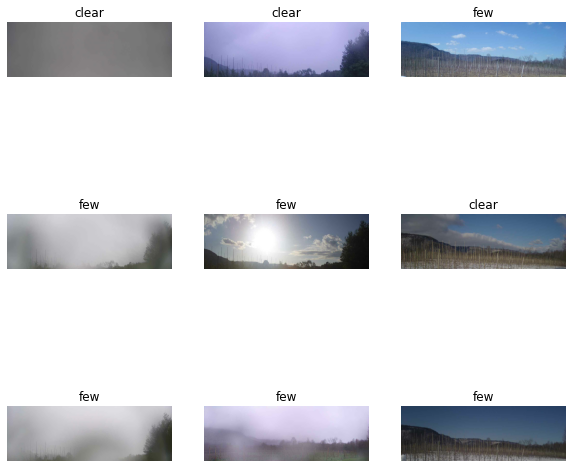

In [35]:
####Working for testing a full dataset 
#Retrieve a batch of images from the test set
#replace val_ds with test_ds
image_batch, label_batch = val_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")